# Models Comparison for TinyML

In [22]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 1

In [24]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [25]:
n_labels = 2 + taskIndex
samples = 30
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [26]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [27]:
y = np.array([int(el) for el in y])
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(18, 42)
(18,)


In [30]:
X_test.shape

(18, 42)

## Model Spotting

In [12]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [13]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))
"""
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))
                                                          """


"\nif n_labels == 5:\n    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, \n                                                           max_features=9, criterion='entropy', max_depth=None,\n                                                           min_samples_split=4, min_samples_leaf=1\n                                                          )))\n\nelse:\n    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, \n                                                           max_features=5, criterion='gini', max_depth=None,\n                                                           min_samples_split=4, min_samples_leaf=1\n                                                          )))\n                                                          "

In [14]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,37 0,14
LR - 0,72 0,19
CART - 0,67 0,10
SVC - 0,70 0,16
RF - 0,83 0,18


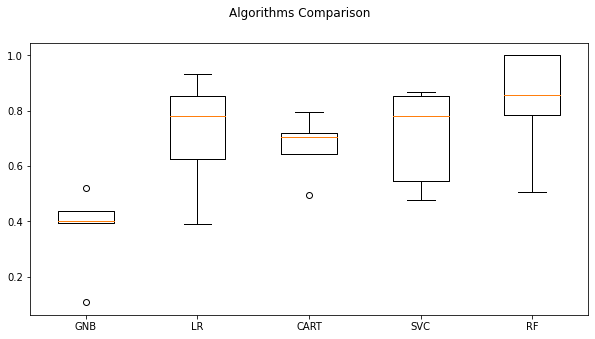

In [15]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [16]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.00      0.00      0.00         6
           2       0.45      0.83      0.59         6

    accuracy                           0.33        18
   macro avg       0.22      0.33      0.26        18
weighted avg       0.22      0.33      0.26        18

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.60      0.50      0.55         6
           2       1.00      0.83      0.91         6

    accuracy                           0.67        18
   macro avg       0.70      0.67      0.68        18
weighted avg       0.70      0.67      0.68        18

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.60

# Neural Network

In [17]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [18]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                1806      
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 13,585
Trainable params: 13,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
9/9 [==============================] - 0s 663us/step - loss: 1.0990 - accuracy: 0.3158
Epoch 2/500
9/9 

9/9 [==============================] - 0s 567us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 154/500
9/9 [==============================] - 0s 586us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 155/500
9/9 [==============================] - 0s 585us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 156/500
9/9 [==============================] - 0s 486us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 157/500
9/9 [==============================] - 0s 659us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 158/500
9/9 [==============================] - 0s 498us/step - loss: 0.0175 - accuracy: 1.0000
Epoch 159/500
9/9 [==============================] - 0s 675us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 160/500
9/9 [==============================] - 0s 539us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 161/500
9/9 [==============================] - 0s 587us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 162/500
9/9 [==============================] - 0s 543us/step - loss: 0.0087 - accuracy: 1.0000
Epoc

9/9 [==============================] - 0s 508us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 235/500
9/9 [==============================] - 0s 547us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 236/500
9/9 [==============================] - 0s 531us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 237/500
9/9 [==============================] - 0s 654us/step - loss: 6.3364e-04 - accuracy: 1.0000
Epoch 238/500
9/9 [==============================] - 0s 509us/step - loss: 0.0108 - accuracy: 1.0000
Epoch 239/500
9/9 [==============================] - 0s 606us/step - loss: 5.2859e-04 - accuracy: 1.0000
Epoch 240/500
9/9 [==============================] - 0s 583us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 241/500
9/9 [==============================] - 0s 555us/step - loss: 0.0184 - accuracy: 0.9825
Epoch 242/500
9/9 [==============================] - 0s 614us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 243/500
9/9 [==============================] - 0s 492us/step - loss: 7.8145e-04 - accuracy:

9/9 [==============================] - 0s 623us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 394/500
9/9 [==============================] - 0s 494us/step - loss: 2.8639e-04 - accuracy: 1.0000
Epoch 395/500
9/9 [==============================] - 0s 527us/step - loss: 3.3324e-04 - accuracy: 1.0000
Epoch 396/500
9/9 [==============================] - 0s 546us/step - loss: 1.4382e-04 - accuracy: 1.0000
Epoch 397/500
9/9 [==============================] - 0s 550us/step - loss: 1.9657e-04 - accuracy: 1.0000
Epoch 398/500
9/9 [==============================] - 0s 562us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 399/500
9/9 [==============================] - 0s 545us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 400/500
9/9 [==============================] - 0s 641us/step - loss: 4.9526e-04 - accuracy: 1.0000
Epoch 401/500
9/9 [==============================] - 0s 529us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 402/500
9/9 [==============================] - 0s 665us/step - loss: 0.0014 - a

9/9 [==============================] - 0s 627us/step - loss: 0.1436 - accuracy: 0.9825
Epoch 44/500
9/9 [==============================] - 0s 525us/step - loss: 0.1326 - accuracy: 0.9649
Epoch 45/500
9/9 [==============================] - 0s 529us/step - loss: 0.1239 - accuracy: 0.9825
Epoch 46/500
9/9 [==============================] - 0s 586us/step - loss: 0.1648 - accuracy: 1.0000
Epoch 47/500
9/9 [==============================] - 0s 528us/step - loss: 0.1253 - accuracy: 1.0000
Epoch 48/500
9/9 [==============================] - 0s 622us/step - loss: 0.1186 - accuracy: 0.9825
Epoch 49/500
9/9 [==============================] - 0s 535us/step - loss: 0.1263 - accuracy: 0.9825
Epoch 50/500
9/9 [==============================] - 0s 647us/step - loss: 0.1087 - accuracy: 1.0000
Epoch 51/500
9/9 [==============================] - 0s 552us/step - loss: 0.1319 - accuracy: 0.9649
Epoch 52/500
9/9 [==============================] - 0s 519us/step - loss: 0.1615 - accuracy: 0.9649
Epoch 53/500


9/9 [==============================] - 0s 532us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 206/500
9/9 [==============================] - 0s 613us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 207/500
9/9 [==============================] - 0s 507us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 208/500
9/9 [==============================] - 0s 608us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 209/500
9/9 [==============================] - 0s 529us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 210/500
9/9 [==============================] - 0s 628us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 211/500
9/9 [==============================] - 0s 552us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 212/500
9/9 [==============================] - 0s 541us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 213/500
9/9 [==============================] - 0s 641us/step - loss: 0.0164 - accuracy: 1.0000
Epoch 214/500
9/9 [==============================] - 0s 549us/step - loss: 0.0039 - accuracy: 1.0000
Epoc

9/9 [==============================] - 0s 595us/step - loss: 3.4441e-04 - accuracy: 1.0000
Epoch 367/500
9/9 [==============================] - 0s 572us/step - loss: 4.7267e-04 - accuracy: 1.0000
Epoch 368/500
9/9 [==============================] - 0s 537us/step - loss: 0.0164 - accuracy: 0.9825
Epoch 369/500
9/9 [==============================] - 0s 568us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 370/500
9/9 [==============================] - 0s 533us/step - loss: 0.0234 - accuracy: 0.9825
Epoch 371/500
9/9 [==============================] - 0s 637us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 372/500
9/9 [==============================] - 0s 560us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 373/500
9/9 [==============================] - 0s 610us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 374/500
9/9 [==============================] - 0s 581us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 375/500
9/9 [==============================] - 0s 577us/step - loss: 0.0011 - accuracy: 1.0

Epoch 446/500
9/9 [==============================] - 0s 563us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 447/500
9/9 [==============================] - 0s 595us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 448/500
9/9 [==============================] - 0s 551us/step - loss: 3.1595e-04 - accuracy: 1.0000
Epoch 449/500
9/9 [==============================] - 0s 530us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 450/500
9/9 [==============================] - 0s 530us/step - loss: 0.0115 - accuracy: 1.0000
Epoch 451/500
9/9 [==============================] - 0s 632us/step - loss: 9.9340e-04 - accuracy: 1.0000
Epoch 452/500
9/9 [==============================] - 0s 525us/step - loss: 9.2926e-04 - accuracy: 1.0000
Epoch 453/500
9/9 [==============================] - 0s 509us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 454/500
9/9 [==============================] - 0s 605us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 455/500
9/9 [==============================] - 0s 480us/step - loss: 0.00

9/9 [==============================] - 0s 554us/step - loss: 0.0760 - accuracy: 0.9655
Epoch 99/500
9/9 [==============================] - 0s 549us/step - loss: 0.0174 - accuracy: 1.0000
Epoch 100/500
9/9 [==============================] - 0s 661us/step - loss: 0.0378 - accuracy: 0.9828
Epoch 101/500
9/9 [==============================] - 0s 573us/step - loss: 0.0216 - accuracy: 1.0000
Epoch 102/500
9/9 [==============================] - 0s 548us/step - loss: 0.0344 - accuracy: 0.9828
Epoch 103/500
9/9 [==============================] - 0s 531us/step - loss: 0.0257 - accuracy: 0.9828
Epoch 104/500
9/9 [==============================] - 0s 543us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 105/500
9/9 [==============================] - 0s 574us/step - loss: 0.0190 - accuracy: 1.0000
Epoch 106/500
9/9 [==============================] - 0s 530us/step - loss: 0.0225 - accuracy: 1.0000
Epoch 107/500
9/9 [==============================] - 0s 544us/step - loss: 0.0104 - accuracy: 1.0000
Epoch

9/9 [==============================] - 0s 570us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 261/500
9/9 [==============================] - 0s 563us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 262/500
9/9 [==============================] - 0s 545us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 263/500
9/9 [==============================] - 0s 518us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 264/500
9/9 [==============================] - 0s 589us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 265/500
9/9 [==============================] - 0s 531us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 266/500
9/9 [==============================] - 0s 577us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 267/500
9/9 [==============================] - 0s 508us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 268/500
9/9 [==============================] - 0s 578us/step - loss: 5.9856e-04 - accuracy: 1.0000
Epoch 269/500
9/9 [==============================] - 0s 583us/step - loss: 0.0066 - accuracy: 1.0000


9/9 [==============================] - 0s 575us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 420/500
9/9 [==============================] - 0s 609us/step - loss: 2.1614e-04 - accuracy: 1.0000
Epoch 421/500
9/9 [==============================] - 0s 606us/step - loss: 5.3388e-04 - accuracy: 1.0000
Epoch 422/500
9/9 [==============================] - 0s 502us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 423/500
9/9 [==============================] - 0s 569us/step - loss: 3.5876e-04 - accuracy: 1.0000
Epoch 424/500
9/9 [==============================] - 0s 562us/step - loss: 2.9598e-04 - accuracy: 1.0000
Epoch 425/500
9/9 [==============================] - 0s 588us/step - loss: 3.6907e-04 - accuracy: 1.0000
Epoch 426/500
9/9 [==============================] - 0s 598us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 427/500
9/9 [==============================] - 0s 512us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 428/500
9/9 [==============================] - 0s 633us/step - loss: 0.0033 - a

9/9 [==============================] - 0s 557us/step - loss: 0.0482 - accuracy: 1.0000
Epoch 70/500
9/9 [==============================] - 0s 536us/step - loss: 0.0481 - accuracy: 0.9828
Epoch 71/500
9/9 [==============================] - 0s 550us/step - loss: 0.0354 - accuracy: 1.0000
Epoch 72/500
9/9 [==============================] - 0s 539us/step - loss: 0.0279 - accuracy: 1.0000
Epoch 73/500
9/9 [==============================] - 0s 627us/step - loss: 0.0408 - accuracy: 0.9828
Epoch 74/500
9/9 [==============================] - 0s 530us/step - loss: 0.0479 - accuracy: 0.9828
Epoch 75/500
9/9 [==============================] - 0s 557us/step - loss: 0.0685 - accuracy: 0.9655
Epoch 76/500
9/9 [==============================] - 0s 610us/step - loss: 0.0453 - accuracy: 1.0000
Epoch 77/500
9/9 [==============================] - 0s 515us/step - loss: 0.0335 - accuracy: 1.0000
Epoch 78/500
9/9 [==============================] - 0s 578us/step - loss: 0.0489 - accuracy: 0.9828
Epoch 79/500


9/9 [==============================] - 0s 596us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 232/500
9/9 [==============================] - 0s 590us/step - loss: 0.0135 - accuracy: 1.0000
Epoch 233/500
9/9 [==============================] - 0s 533us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 234/500
9/9 [==============================] - 0s 576us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 235/500
9/9 [==============================] - 0s 526us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 236/500
9/9 [==============================] - 0s 613us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 237/500
9/9 [==============================] - 0s 542us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 238/500
9/9 [==============================] - 0s 592us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 239/500
9/9 [==============================] - 0s 613us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 240/500
9/9 [==============================] - 0s 512us/step - loss: 0.0019 - accuracy: 1.0000
Epoc

9/9 [==============================] - 0s 534us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 313/500
9/9 [==============================] - 0s 584us/step - loss: 9.6422e-04 - accuracy: 1.0000
Epoch 314/500
9/9 [==============================] - 0s 524us/step - loss: 5.7187e-04 - accuracy: 1.0000
Epoch 315/500
9/9 [==============================] - 0s 513us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 316/500
9/9 [==============================] - 0s 534us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 317/500
9/9 [==============================] - 0s 538us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 318/500
9/9 [==============================] - 0s 598us/step - loss: 6.4956e-04 - accuracy: 1.0000
Epoch 319/500
9/9 [==============================] - 0s 513us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 320/500
9/9 [==============================] - 0s 534us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 321/500
9/9 [==============================] - 0s 581us/step - loss: 7.7299e-04 - accur

9/9 [==============================] - 0s 522us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 393/500
9/9 [==============================] - 0s 544us/step - loss: 0.0107 - accuracy: 1.0000
Epoch 394/500
9/9 [==============================] - 0s 552us/step - loss: 6.5107e-04 - accuracy: 1.0000
Epoch 395/500
9/9 [==============================] - 0s 642us/step - loss: 4.2760e-04 - accuracy: 1.0000
Epoch 396/500
9/9 [==============================] - 0s 552us/step - loss: 2.8578e-04 - accuracy: 1.0000
Epoch 397/500
9/9 [==============================] - 0s 534us/step - loss: 9.2421e-04 - accuracy: 1.0000
Epoch 398/500
9/9 [==============================] - 0s 568us/step - loss: 3.5132e-04 - accuracy: 1.0000
Epoch 399/500
9/9 [==============================] - 0s 518us/step - loss: 8.1420e-04 - accuracy: 1.0000
Epoch 400/500
9/9 [==============================] - 0s 589us/step - loss: 4.6854e-04 - accuracy: 1.0000
Epoch 401/500
9/9 [==============================] - 0s 530us/step - loss: 0.

9/9 [==============================] - 0s 533us/step - loss: 0.0804 - accuracy: 1.0000
Epoch 42/500
9/9 [==============================] - 0s 532us/step - loss: 0.1005 - accuracy: 0.9828
Epoch 43/500
9/9 [==============================] - 0s 574us/step - loss: 0.0913 - accuracy: 0.9828
Epoch 44/500
9/9 [==============================] - 0s 551us/step - loss: 0.0540 - accuracy: 1.0000
Epoch 45/500
9/9 [==============================] - 0s 622us/step - loss: 0.0987 - accuracy: 0.9655
Epoch 46/500
9/9 [==============================] - 0s 543us/step - loss: 0.0905 - accuracy: 0.9655
Epoch 47/500
9/9 [==============================] - 0s 554us/step - loss: 0.0776 - accuracy: 1.0000
Epoch 48/500
9/9 [==============================] - 0s 521us/step - loss: 0.0957 - accuracy: 0.9828
Epoch 49/500
9/9 [==============================] - 0s 518us/step - loss: 0.0662 - accuracy: 0.9828
Epoch 50/500
9/9 [==============================] - 0s 550us/step - loss: 0.0773 - accuracy: 0.9655
Epoch 51/500


9/9 [==============================] - 0s 516us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 204/500
9/9 [==============================] - 0s 624us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 205/500
9/9 [==============================] - 0s 522us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 206/500
9/9 [==============================] - 0s 547us/step - loss: 0.0214 - accuracy: 0.9828
Epoch 207/500
9/9 [==============================] - 0s 502us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 208/500
9/9 [==============================] - 0s 506us/step - loss: 0.0133 - accuracy: 1.0000
Epoch 209/500
9/9 [==============================] - 0s 607us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 210/500
9/9 [==============================] - 0s 564us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 211/500
9/9 [==============================] - 0s 539us/step - loss: 5.4968e-04 - accuracy: 1.0000
Epoch 212/500
9/9 [==============================] - 0s 553us/step - loss: 0.0051 - accuracy: 1.0000


9/9 [==============================] - 0s 506us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 363/500
9/9 [==============================] - 0s 652us/step - loss: 3.4144e-04 - accuracy: 1.0000
Epoch 364/500
9/9 [==============================] - 0s 506us/step - loss: 0.0313 - accuracy: 0.9828
Epoch 365/500
9/9 [==============================] - 0s 602us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 366/500
9/9 [==============================] - 0s 569us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 367/500
9/9 [==============================] - 0s 594us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 368/500
9/9 [==============================] - 0s 597us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 369/500
9/9 [==============================] - 0s 527us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 370/500
9/9 [==============================] - 0s 584us/step - loss: 8.7153e-04 - accuracy: 1.0000
Epoch 371/500
9/9 [==============================] - 0s 526us/step - loss: 0.0012 - accuracy: 1.0

## Train and Test

In [19]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 13,585
Trainable params: 13,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 0s 11ms/step - loss: 1.1187 - accuracy: 0.3704 - val_loss: 1.088

8/8 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.7148 - val_accuracy: 0.8333
Epoch 111/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.7118 - val_accuracy: 0.8333
Epoch 112/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.7097 - val_accuracy: 0.8333
Epoch 113/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.7103 - val_accuracy: 0.8333
Epoch 114/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.7107 - val_accuracy: 0.8333
Epoch 115/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.7157 - val_accuracy: 0.8333
Epoch 116/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0448 - accuracy: 0.9815 - val_loss: 0.7281 - val_accuracy: 0.8333
Epoch 117/500
8/8 [========

8/8 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.8376 - val_accuracy: 0.7222
Epoch 227/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7765 - val_accuracy: 0.7778
Epoch 228/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.7552 - val_accuracy: 0.8889
Epoch 229/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7500 - val_accuracy: 0.8889
Epoch 230/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7476 - val_accuracy: 0.8889
Epoch 231/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.7564 - val_accuracy: 0.8889
Epoch 232/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.8026 - val_accuracy: 0.8333
Epoch 233/500
8/8 [========

8/8 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.1508 - val_accuracy: 0.7778
Epoch 285/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.1711 - val_accuracy: 0.7778
Epoch 286/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1828 - val_accuracy: 0.7778
Epoch 287/500
8/8 [==============================] - 0s 2ms/step - loss: 7.8623e-04 - accuracy: 1.0000 - val_loss: 1.1865 - val_accuracy: 0.7778
Epoch 288/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.1677 - val_accuracy: 0.7778
Epoch 289/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.1252 - val_accuracy: 0.7778
Epoch 290/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1013 - val_accuracy: 0.7778
Epoch 291/500
8/8 [====

Epoch 342/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.1875 - val_accuracy: 0.7222
Epoch 343/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.1780 - val_accuracy: 0.7222
Epoch 344/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.1445 - val_accuracy: 0.7222
Epoch 345/500
8/8 [==============================] - 0s 2ms/step - loss: 5.0006e-04 - accuracy: 1.0000 - val_loss: 1.0826 - val_accuracy: 0.7778
Epoch 346/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.0475 - val_accuracy: 0.8333
Epoch 347/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9689 - val_accuracy: 0.8333
Epoch 348/500
8/8 [==============================] - 0s 2ms/step - loss: 7.2757e-04 - accuracy: 1.0000 - val_loss: 0.9442 - val_accuracy: 0.8333
Epoch

8/8 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.0419 - val_accuracy: 0.7778
Epoch 457/500
8/8 [==============================] - 0s 2ms/step - loss: 1.3206e-04 - accuracy: 1.0000 - val_loss: 0.9784 - val_accuracy: 0.7778
Epoch 458/500
8/8 [==============================] - 0s 2ms/step - loss: 5.0285e-04 - accuracy: 1.0000 - val_loss: 0.9566 - val_accuracy: 0.8333
Epoch 459/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4177e-04 - accuracy: 1.0000 - val_loss: 0.9472 - val_accuracy: 0.8889
Epoch 460/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.9674 - val_accuracy: 0.8889
Epoch 461/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9925 - val_accuracy: 0.8889
Epoch 462/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0020 - val_accuracy: 0.8889
Epoch 463/500
8

In [20]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.71      0.83      0.77         6
           2       1.00      0.83      0.91         6

    accuracy                           0.78        18
   macro avg       0.79      0.78      0.78        18
weighted avg       0.79      0.78      0.78        18



# Export Models in C code

In [21]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp0qx0m7tf/assets
